In [40]:
from keras.applications import VGG16

In [41]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [42]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# First way. All data throw and then use it for separate Neural Network as input.

In [43]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [44]:
base_dir = "Data"

In [45]:
train_dir = os.path.join(base_dir, 'train')

In [46]:
validation_dir = os.path.join(base_dir, 'validation')

In [47]:
test_dir = os.path.join(base_dir, 'test')

## Datagen

In [48]:
datagen = ImageDataGenerator(rescale=1./255)

In [49]:
batch_size = 20

In [50]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    # Because block5_pool (MaxPooling2D)   (None, 4, 4, 512)      
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),  #The dimensions to which all images found will be resized.
        batch_size=batch_size,
        class_mode='binary'
    )
    
    i=0
    for inputs_batch, labels_batch in generator:
        
        # Features
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1)* batch_size] = features_batch
        
        # Labels
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i+=1
        
        if i*batch_size >=sample_count:
            break
            pass
        
        return features, labels

In [51]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Checking

In [52]:
train_features.shape, train_labels.shape

((2000, 4, 4, 512), (2000,))

<center><h2>We have done something like this<h2></center>
<img src='https://m-alcu.github.io/assets/stride2.gif'>

## To tensor

In [53]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512)) # or just "-1"

In [54]:
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))

In [55]:
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

# Dense

In [56]:
import time

In [57]:
from keras import models, layers, optimizers

In [58]:
model = models.Sequential()

In [59]:
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))

In [60]:
model.add(layers.Dropout(0.5))

In [61]:
model.add(layers.Dense(1, activation='sigmoid'))

In [62]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

In [63]:
history = model.fit(train_features, train_labels,
                   epochs = 10,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels),
                   verbose=1)
time.sleep(3)

Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6925 - acc: 0.9940 - val_loss: 0.6856 - val_acc: 0.9930
Epoch 2/10
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6827 - acc: 0.9960 - val_loss: 0.6790 - val_acc: 0.9910
Epoch 3/10
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6754 - acc: 0.9965 - val_loss: 0.6720 - val_acc: 0.9930
Epoch 4/10
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6693 - acc: 0.9965 - val_loss: 0.6648 - val_acc: 0.9910
Epoch 5/10
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6607 - acc: 0.9970 - val_loss: 0.6575 - val_acc: 0.9920
Epoch 6/10
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6518 - acc: 0.9985 - val_loss: 0.6498 - val_acc: 0.9920
Epoch 7/10
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6441 - acc: 0.9985 - val_loss: 0.6421 - val_acc: 0.9920
Epoch 8

# Visualization

In [64]:
import matplotlib.pyplot as plt

In [65]:
import seaborn as sns
sns.set(style="whitegrid")

In [66]:
acc = history.history['acc']

val_acc = history.history['val_acc']

loss = history.history['loss']

val_loss = history.history['val_loss']

In [67]:
acc 

[0.994, 0.996, 0.9965, 0.9965, 0.997, 0.9985, 0.9985, 0.999, 0.999, 0.999]

In [68]:
epochs = range(1, len(acc)+1)

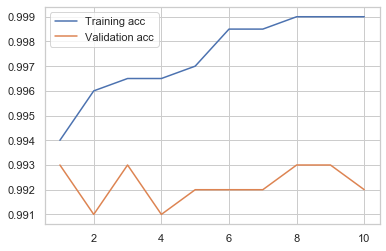

In [69]:
sns.lineplot(epochs, acc, label = 'Training acc')
sns.lineplot(epochs, val_acc, label='Validation acc')

In [70]:
max(val_acc)

0.9929999709129333

## Training last 3 layers

In [71]:
set_trainable = True

In [72]:
for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [73]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())

In [74]:
model.add(layers.Dense(256, activation='relu'))

In [75]:
model.add(layers.Dense(1, activation='sigmoid'))

## Training

In [76]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [77]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

In [78]:
history = model.fit(train_generator,
                    steps_per_epoch=10,
                    epochs=9,
                    validation_data=validation_generator,
                    validation_steps=3,
                    max_queue_size=1,
                    verbose=1)
time.sleep(3)

Epoch 1/9
10/10 [==============================] - 496s 50s/step - loss: 0.6504 - acc: 0.5900 - val_loss: 0.6102 - val_acc: 0.7500
Epoch 2/9
10/10 [==============================] - 502s 50s/step - loss: 0.6173 - acc: 0.6600 - val_loss: 0.5903 - val_acc: 0.7500
Epoch 3/9
10/10 [==============================] - 518s 52s/step - loss: 0.5896 - acc: 0.6650 - val_loss: 0.4229 - val_acc: 0.7833
Epoch 4/9
10/10 [==============================] - 520s 52s/step - loss: 0.5308 - acc: 0.7600 - val_loss: 0.3788 - val_acc: 0.8833
Epoch 5/9
10/10 [==============================] - 516s 52s/step - loss: 0.4629 - acc: 0.8150 - val_loss: 0.4142 - val_acc: 0.8500
Epoch 6/9
10/10 [==============================] - 483s 48s/step - loss: 0.5025 - acc: 0.7450 - val_loss: 0.3365 - val_acc: 0.8500
Epoch 7/9
10/10 [==============================] - 474s 47s/step - loss: 0.3836 - acc: 0.8500 - val_loss: 0.3393 - val_acc: 0.8167
Epoch 8/9
10/10 [==============================] - 497s 50s/step - loss: 0.4499 - a

In [80]:
model.save('models/retrained_augmentation_model')

In [81]:
acc = history.history['acc']

val_acc = history.history['val_acc']

loss = history.history['loss']

val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

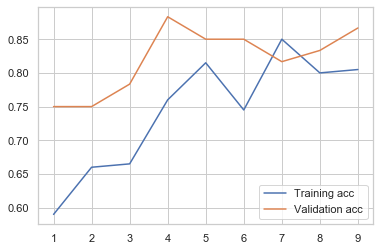

In [82]:
sns.lineplot(epochs, acc, label = 'Training acc')
sns.lineplot(epochs, val_acc, label='Validation acc')

## Smoothing

In [84]:
def smooth_curve(points, factor = 0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            #  It is like being dependent on the prevoius result. It also gonna smooth anomalies
            smoothed_points.append(previous * factor + point * (1-factor))
            pass
        
        else:
            smoothed_points.append(point)
            pass
        pass
    
    return smoothed_points

Text(0.5, 1.0, 'Smoothed data')

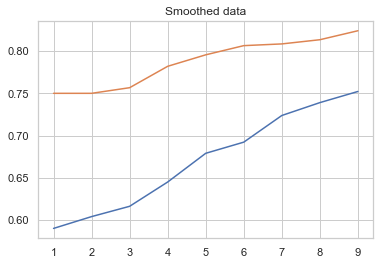

In [87]:
sns.lineplot(epochs, smooth_curve(acc))
sns.lineplot(epochs, smooth_curve(val_acc)).set_title('Smoothed data')

# Evaluating

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size(150,150),
    batch_size=20,
    class_mode='binary'
)

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

### WOW that is HUGE</br> It would be one of the best results a few years ago<br>Now, due to modern tech we can access a lot of new methods